Target: Input SMILES of a fluorinated compounds, plot its 19F NMR spectra and give confidence levels.

Plan to get 19F NMR of the following PFAS:


In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks

# plot
import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

RANDOM_STATE = 1

src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    atomic_features_3D,
    hose_code,
)  # Some common methods I defined

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning

In [2]:
data_path = os.path.join("..", "dataset", "Raw_PFAS 19F NMR spectra data.csv")

all_fluorinated_compounds = pd.read_csv(data_path, index_col=0)

print(all_fluorinated_compounds.shape)
all_fluorinated_compounds.head()

(647, 82)


,Group,IsPFAS(haveCF2),CAS,Compound name,Code,Solvent_used_for_NMR,Source,Note,SMILES,Internal Standard,FluorineInConjSystem,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,Per- and polyfluorinated carboxylic acids,True,NaN,perfluoropropionic acid,COOH_1,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-122.45,-122.45,NaN,-83.40,-83.40,-83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Per- and polyfluorinated carboxylic acids,True,NaN,perfluorobutanoic acid,COOH_2,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.78,-119.78,NaN,-127.39,-127.39,NaN,-81.14,-81.14,-81.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Per- and polyfluorinated carboxylic acids,True,NaN,perfluoropentanoic acid,COOH_3,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.41,-119.41,NaN,-123.99,-123.99,NaN,-126.26,-126.26,NaN,-81.19,-81.19,-81.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Per- and polyfluorinated carboxylic acids,True,NaN,perfluorohexanoic acid,COOH_4,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.23,-119.23,NaN,-122.87,-122.87,NaN,-123.25,-123.25,NaN,-126.44,-126.44,NaN,-81.06,-81.06,-81.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Per- and polyfluorinated carboxylic acids,True,NaN,perfluoroheptanoic acid,COOH_5,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,-119.14,-119.14,NaN,-122.01,-122.01,NaN,-122.99,-122.99,NaN,-122.99,-122.99,NaN,-126.29,-126.29,NaN,-80.96,-80.96,-80.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# I. PFAS in EPA1633 that not included in our Dataset

In [3]:
file_path = os.path.join("..", "dataset", "EPA1633 PFAS_information.csv")
EPA1633 = pd.read_csv(file_path)
EPA1633

,Analyte Name,Acronym,CAS Number,MW,Molecular formula,SMILES
0,Hexafluoropropylene oxide dimer acid,HFPO-DA,13252-13-6,330.050,C6HF11O3,O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F
1,"4,8-Dioxa-3H-perfluorononanoic acid",ADONA,919005-14-4,378.070,C7H2F12O4,O=C(O)C(F)(F)C(F)OC(F)(F)C(F)(F)C(F)(F)OC(F)(F)F
2,9-Chlorohexadecafluoro-3-oxanonane-1-sulfonic ...,9Cl-PF3ONS,756426-58-1,532.580,C8HClF16O4S,O=S(=O)(O)C(F)(F)C(F)(F)OC(F)(F)C(F)(F)C(F)(F)...
3,11-Chloroeicosafluoro-3-oxaundecane-1-sulfonic...,11Cl-PF3OUdS,763051-92-9,632.600,C10ClF20HO4S,O=S(=O)(O)C(F)(F)C(F)(F)OC(F)(F)C(F)(F)C(F)(F)...
4,Perfluoro-3-methoxypropanoic acid,PFMPA,377-73-1,230.040,C4HF7O3,O=C(O)C(F)(F)C(F)(F)OC(F)(F)F
...,...,...,...,...,...,...
35,N-methyl perfluorooctanesulfonamidoethanol,NMeFOSE,24448-09-7,557.224,C11H8F17NO3S,CN(C(O)(F)C(F)(F)F)S(=O)(=O)C(F)(F)C(F)(F)C(F)...
36,N-ethyl perfluorooctanesulfonamidoethanol,NEtFOSE,1691-99-2,571.250,C12H10F17NO3S,CCN(C(O)(F)C(F)(F)F)S(=O)(=O)C(F)(F)C(F)(F)C(F...
37,3-Perfluoropropyl propanoic acid,3:3FTCA,356-02-5,242.090,C6H5F7O2,O=C(O)CCC(F)(F)C(F)(F)C(F)(F)F
38,"2H,2H,3H,3H-Perfluorooctanoic acid",5:3FTCA,914637-49-3,342.110,C8H5F11O2,O=C(O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


In [4]:
EPA_SMILES = []
for i in EPA1633["SMILES"]:
    EPA_SMILES.append(i)

print("Number of all PFAS in EPA1633")
print(len(EPA_SMILES))

for index, row in all_fluorinated_compounds.iterrows():
    if row["SMILES"] in EPA_SMILES:
        print(row["Code"], row["Compound name"])
        EPA_SMILES.remove(row["SMILES"])

print("\nNumber of EPA1633 PFAS that has no 19F NMR spectrum in my dataset")
print(len(EPA_SMILES))

Number of all PFAS in EPA1633
40
COOH_2 perfluorobutanoic acid
COOH_3 perfluoropentanoic acid
COOH_4 perfluorohexanoic acid
COOH_5 perfluoroheptanoic acid
COOH_6 perfluorooctanoic acid
COOH_7 perfluorononanoic acid
COOH_8 perfluorododecanoic acid
COOH_9 perfluorotetradecanoic acid
SO3H_3 perfluorobutane sulfonic acid
SO3H_5 perfluorohexane sulfonic acid
SO3H_6 perfluorooctane sulfonic acid
SO3H_7 perfluorodecane sulfonic acid
SO3H_10 6:2 fluorotelomer sulfonic acid
SO3H_13 perfluorooctane sulfonamide
SO3H_15 N-ethyl-1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-N-(2-hydroxyethyl)octane-1-sulfonamide
ether_11 Perfluoro-3-methoxypropanoic acid
ether_12 Perfluoro-4-methoxybutanoic acid
ether_13 2,3,3,3-tetrafluoro-2-(heptafluoropropoxy)propanoic acid
ether_15 Perfluoro-3,6-dioxaheptanoic acid
COOH_29 Perfluorodecanoic acid
COOH_30 Perfluoroundecanoic acid
COOH_31 Perfluorotridecanoic acid
SO3H_18 Perfluorobutanesulfonic acid
SO3H_21 Perfluoro-1-heptanesulfonic acid
SO3H_24 1H, 1H, 2H,

In [5]:
unreported_EPA1633 = EPA1633[EPA1633["SMILES"].isin(EPA_SMILES)]
unreported_EPA1633

,Analyte Name,Acronym,CAS Number,MW,Molecular formula,SMILES
1,"4,8-Dioxa-3H-perfluorononanoic acid",ADONA,919005-14-4,378.070,C7H2F12O4,O=C(O)C(F)(F)C(F)OC(F)(F)C(F)(F)C(F)(F)OC(F)(F)F
2,9-Chlorohexadecafluoro-3-oxanonane-1-sulfonic ...,9Cl-PF3ONS,756426-58-1,532.580,C8HClF16O4S,O=S(=O)(O)C(F)(F)C(F)(F)OC(F)(F)C(F)(F)C(F)(F)...
3,11-Chloroeicosafluoro-3-oxaundecane-1-sulfonic...,11Cl-PF3OUdS,763051-92-9,632.600,C10ClF20HO4S,O=S(=O)(O)C(F)(F)C(F)(F)OC(F)(F)C(F)(F)C(F)(F)...
24,Perfluorononanesulfonic acid,PFNS,68259-12-1,550.140,C9HF19O3S,O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...
26,Perfluorododecanesulfonic acid,PFDoS,79780-39-5,700.160,C12HF25O3S,O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...
33,N-methyl perfluorooctanesulfonamide,NMeFOSA,31506-32-8,513.170,C9H4F17NO2S,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...
35,N-methyl perfluorooctanesulfonamidoethanol,NMeFOSE,24448-09-7,557.224,C11H8F17NO3S,CN(C(O)(F)C(F)(F)F)S(=O)(=O)C(F)(F)C(F)(F)C(F)...
36,N-ethyl perfluorooctanesulfonamidoethanol,NEtFOSE,1691-99-2,571.250,C12H10F17NO3S,CCN(C(O)(F)C(F)(F)F)S(=O)(=O)C(F)(F)C(F)(F)C(F...
37,3-Perfluoropropyl propanoic acid,3:3FTCA,356-02-5,242.090,C6H5F7O2,O=C(O)CCC(F)(F)C(F)(F)C(F)(F)F
39,3-Perfluoroheptyl propanoic acid,7:3FTCA,812-70-4,442.120,C10H5F15O2,O=C(O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...


# II. Retrain our model use the whole dataset we collected

In [6]:
all_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    all_fluorinated_compounds, neighbor_num=5, with_additional_info=False
)

all_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)
all_fluorinated_compounds_w_Desc = all_fluorinated_compounds_w_Desc.apply(
    pd.to_numeric, errors="ignore"
)

# Save to file
file_path = os.path.join(
    "..",
    "artifacts",
    "temp",
    "Output_all_fluorinated_compounds_3d_neighber5_w_all_CDK_descriptors.csv",
)
all_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")
all_fluorinated_compounds_w_Desc.shape

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/1860458344.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  all_fluorinated_compounds_w_Desc = all_fluorinated_compounds_w_Desc.apply(


(3603, 119)

In [7]:
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor5_xgboost.pkl"
)
with open(file_path, "rb") as f:
    train_cols = pickle.load(f)

dataset = all_fluorinated_compounds_w_Desc[train_cols]

dataset = dataset.dropna(subset=["NMR_Peaks"])

y = dataset["NMR_Peaks"]
X = dataset.drop(["NMR_Peaks"], axis=1)
X = X.apply(pd.to_numeric)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 2, 5, 10],
    "reg_lambda": [0.1, 2, 5, 10],
}

# Define a custom RMSE scoring function


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Use the custom RMSE function with make_scorer
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}


xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          random_state=None, ...),
                   param_distributions={'gamma': [0.1, 0.2, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [2, 3, 4],
                                        'n_estimators': [50, 100, 150],
                                        'reg_alpha': [0.1, 2, 5, 10],
                                        'reg_lambda': [0.1, 2, 5, 10],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=1, refit='mae',
                   scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2',
                            'rmse': make_scorer(rmse, response_method='predict')},
                   verbose=1)

In [8]:
# Get the best parameters
best_params = random_search.best_params_
cv_results = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-cv_results["mean_test_mae"]):.2f} ± {np.std(-cv_results["mean_test_mae"]):.2f}'
)
print(f"Root Mean Squared Error (RMSE): {np.mean(cv_results['mean_test_rmse']):.2f}")
print(
    f'R^2 Score: {np.mean(cv_results["mean_test_r2"]):.2f} ± {np.std(-cv_results["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

file_path = os.path.join(
    "..",
    "artifacts",
    "models",
    "Final_xgboost_model_3D_descriptors_n5_full_dataset_Random_Search.json",
)
best_model.save_model(file_path)

Best parameters found: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 10.87 ± 6.17
Root Mean Squared Error (RMSE): 15.60
R^2 Score: 0.69 ± 0.23


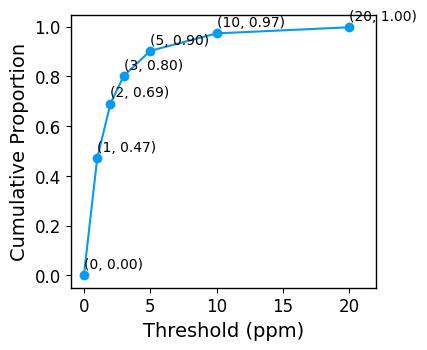

R2 = 0.99
RMSE = 3.45
MAE = 2.028988450931046


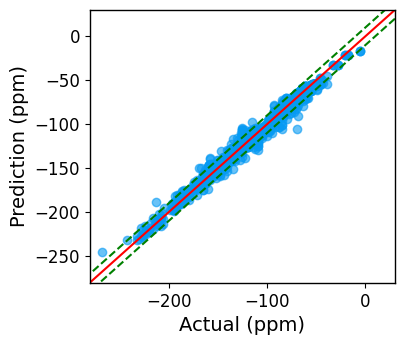

In [9]:
base_file_path = os.path.join("..", "artifacts", "models")
results_table_neighbor_5 = (
    atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
        best_model_file_path=os.path.join(
            base_file_path,
            "Final_xgboost_model_3D_descriptors_n5_full_dataset_Random_Search.json",
        ),
        columns_file_path=os.path.join(
            base_file_path, "column_names_neighbor5_xgboost.pkl"
        ),
        neighbor_num=5,
        test_dataset=all_fluorinated_compounds,
    )
)

In [10]:
HOSE_database_all_fluorianted_compounds = hose_code.getHoseCodeContent(
    all_fluorinated_compounds, max_radius=6
)

file_path = os.path.join(
    "..", "artifacts", "temp", "HOSE_database_all_fluorianted_compounds.csv"
)
HOSE_database_all_fluorianted_compounds.to_csv(file_path, encoding="UTF-8")

HOSE_database_all_fluorianted_compounds.head(3)

,0,1,2,3,4,5,NMR_Peaks
4_COOH_1,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/=OO,FFF,/)","F-1;C(CCF/=OO,FFF,/,,,,)","F-1;C(CCF/=OO,FFF,/,,,,)/","F-1;C(CCF/=OO,FFF,/,,,,)//",-122.45
5_COOH_1,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/=OO,FFF,/)","F-1;C(CCF/=OO,FFF,/,,,,)","F-1;C(CCF/=OO,FFF,/,,,,)/","F-1;C(CCF/=OO,FFF,/,,,,)//",-122.45
7_COOH_1,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/CFF,,/)","F-1;C(CFF/CFF,,/=OO,,)","F-1;C(CFF/CFF,,/=OO,,),/","F-1;C(CFF/CFF,,/=OO,,),//",-83.4


## Streamline the process

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor/notebooks/../src/common.py:482: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = real_PFAS_spectra_df["fluorinated_compounds"][0]


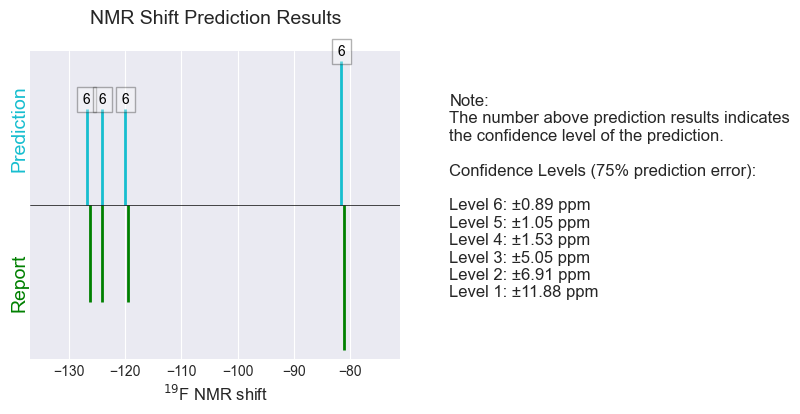

,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,4,6,-119.410000,-119.96,0.55
1,5,6,-119.410000,-119.96,0.55
2,7,6,-123.990000,-124.02,0.03
3,8,6,-123.990000,-124.02,0.03
4,10,6,-126.260000,-126.80,0.54
5,11,6,-126.260000,-126.80,0.54
6,13,6,-81.190000,-81.61,0.42
7,14,6,-81.190000,-81.61,0.42
8,15,6,-81.190000,-81.61,0.42


In [11]:
smiles = "O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F"  # In our dataset
# smiles = 'O=C(O)C(F)(F)C(F)OC(F)(F)C(F)(F)C(F)(F)OC(F)(F)F'  # Not in dataset

common.predictor(smiles=smiles)

## Apply our application to predict 10 random PFAS from our lab

In [12]:
def visualize_experimental_data_vs_prediction(results, experimental_data_file_name):
    # Set style for better visualization
    plt.style.use("seaborn-v0_8-darkgrid")

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), width_ratios=[3, 1])
    fig.subplots_adjust(hspace=0.1)

    # Prepare data
    code = results["fluorinated_compounds"][0]

    predicted_PFAS_spectra_df = results[
        ["fluorinated_compounds", "atom_index", "ensembeled_model"]
    ]
    predicted_PFAS_spectra_df = predicted_PFAS_spectra_df.pivot(
        index="fluorinated_compounds", columns="atom_index", values="ensembeled_model"
    )

    # Colors for better contrast
    actual_color = "g"  # Green
    predict_color = "C9"  # Blue

    # Get predicted value counts
    predict = predicted_PFAS_spectra_df.loc[code, :].value_counts()

    # Plot in the first subplot (ax1)
    # plot experimental data
    file_path = os.path.join("..", "artifacts", "temp", experimental_data_file_name)
    exp_spectrum = pd.read_csv(file_path)
    x_actual = exp_spectrum.iloc[:, 0]
    y_actual = exp_spectrum.iloc[:, 1]
    y_scaled = (y_actual / np.max(y_actual)) * predict.values.max()

    ax1.plot(x_actual, -y_scaled, color=actual_color, label="actual", linewidth=1)

    # Plot predicted values
    ax1.vlines(
        predict.index,
        ymin=0,
        ymax=predict.values,
        color=predict_color,
        label="Prediction",
        linewidth=2,
    )

    # Add similarity levels
    #     temp = results[results['fluorinated_compounds'] == 'temp']
    for i, j in zip(predict.index, predict.values):
        similarity_level = results[results["ensembeled_model"] == i][
            "similarity_levels"
        ]
        if not similarity_level.empty:
            ax1.text(
                i,
                j + 0.05,
                similarity_level.iloc[0],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                bbox=dict(facecolor="white", alpha=0.3),
            )

    # Set plot limits and labels
    x_min = predict.index.min() - 10
    x_max = predict.index.max() + 10
    y_max = predict.values.max() + 0.2

    ax1.set_xlim([x_min, x_max])
    ax1.set_ylim([-y_max, y_max])

    # Add labels
    ax1.text(
        x_min - 2,
        y_max / 2,
        "Prediction",
        color=predict_color,
        rotation=90,
        ha="center",
        va="center",
        fontsize=14,
    )
    ax1.text(
        x_min - 2,
        -y_max / 2,
        "Experiment",
        color=actual_color,
        rotation=90,
        ha="center",
        va="center",
        fontsize=14,
    )

    ax1.set_xlabel(r"$^{19}$F NMR shift", fontsize=12)
    ax1.set_yticks([])
    ax1.axhline(0, color="k", linewidth=0.5)
    ax1.set_title("NMR Shift Prediction Results", fontsize=14, pad=20)

    # Add confidence level information in the second subplot (ax2)
    confidence_data = {
        "Level": [6, 5, 4, 3, 2, 1],
        "Error": [0.89, 1.05, 1.53, 5.05, 6.91, 11.88],
    }

    ax2.axis("off")
    ax2.set_xlim(0, 2)  # Adjust limits as needed
    ax2.set_ylim(0, 2)
    table_text = (
        "Note:\n"
        + "The number above prediction results indicates\n"
        + "the confidence level of the prediction.\n\n"
        + "Confidence Levels (75% prediction error):\n\n"
    )
    for level, error in zip(confidence_data["Level"], confidence_data["Error"]):
        table_text += f"Level {level}: ±{error} ppm\n"
    ax2.text(
        0,
        1,
        table_text,
        ha="left",
        va="center",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="white", alpha=0.9),
    )

    plt.show()

    details = results[
        [
            "atom_index",
            "similarity_levels",
            "actual",
            "ensembeled_model",
            "ensembeled_model_error",
        ]
    ].rename(
        columns={
            "atom_index": "Atom Index",
            "similarity_levels": "Confidence Level",
            "actual": "Report Values",
            "ensembeled_model": "Prediction Results",
            "ensembeled_model_error": "Prediction Error",
        }
    )
    details.reset_index(drop=True, inplace=True)
    # Display molecular structure if available
    file_path = os.path.join("..", "artifacts", "temp")
    if os.path.exists(os.path.join(file_path, "temp.png")):
        filepath = os.path.join(file_path, "temp.png")
        display(Image(filepath))

    # Display detailed results in a styled table
    # Style the dataframe
    styled_details = (
        details.style.set_properties(**{"text-align": "center"})
        .format({"Prediction Results": "{:.2f}", "Prediction Error": "{:.2f}"})
        .set_table_styles(
            [
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "#f8f9fa"),
                        ("color", "black"),
                        ("font-weight", "bold"),
                        ("text-align", "center"),
                        ("padding", "8px"),
                    ],
                },
                {"selector": "td", "props": [("padding", "8px")]},
            ]
        )
    )

    # Detect peaks in y
    peaks, properties = find_peaks(y_scaled, height=0.1, distance=10, prominence=0.05)

    # Get peak x and y values
    x_peaks = x_actual[peaks]
    y_peaks = y_scaled[peaks]

    # Print peak positions and heights
    for x_peak, y_peak in zip(x_peaks, y_peaks):
        print(f"Peak at {x_peak} with relative height {y_peak}")

    display(styled_details)

In [13]:
def compare_prediction_w_experimental_data(
    smiles,
    experimental_data_file_name,
    train_fluorinated_compounds_file_path=os.path.join(
        "..", "dataset", "Raw_PFAS 19F NMR spectra data.csv"
    ),
    HOSE_Code_database_file_path=os.path.join(
        "..", "artifacts", "temp", "HOSE_database_all_fluorianted_compounds.csv"
    ),
    best_XGBoost_mode_file_path=os.path.join(
        "..",
        "artifacts",
        "models",
        "Final_xgboost_model_3D_descriptors_n5_full_dataset_Random_Search.json",
    ),
):
    """
    Compare the prediction results with experimental data
    """
    # Generate sdf file from SMILES
    atomic_features_3D.get_sdf_file(smiles)
    # Generate CDK descriptors and Neighbors information
    atomic_features_3D.get_descriptors_and_neighbors_info()

    # Use the CDK descriptors and Neighbors information to get the features table
    train_dataset = pd.read_csv(train_fluorinated_compounds_file_path, index_col=0)
    dataset = atomic_features_3D.get_test_fluorianted_compounds_info(
        smiles, train_dataset
    )

    NMR_peaks_with_desc = atomic_features_3D.get_features_table(dataset)

    # Get Prediction results from HOSE model
    HOSE_results = hose_code.get_HOSE_prediction_results_table(
        HOSE_Code_database_file_path, dataset
    )

    # Get Prediction results from XGBoost model
    XGBoost_results = common.get_XGBoost_model_results(
        best_model_file_path=best_XGBoost_mode_file_path,
        columns_file_path=os.path.join(
            "..", "artifacts", "models", "column_names_neighbor5_xgboost.pkl"
        ),
        fluorinated_compounds_w_Desc=NMR_peaks_with_desc,
    )
    combined_prediction = pd.DataFrame()
    combined_prediction = HOSE_results.copy()
    combined_prediction.rename(
        columns={"prediction": "HOSE_model_prediction"}, inplace=True
    )
    combined_prediction = combined_prediction[
        ["actual", "similarity_levels", "HOSE_model_prediction"]
    ]
    combined_prediction["XGBoost_model_prediction"] = XGBoost_results["prediction"]

    ensembled_XGBoost_and_HOSE = []
    for i, row in combined_prediction.iterrows():
        if row["similarity_levels"] >= 4:
            ensembled_XGBoost_and_HOSE.append(row["HOSE_model_prediction"])
        else:
            ensembled_XGBoost_and_HOSE.append(row["XGBoost_model_prediction"])

    combined_prediction["ensembeled_model"] = ensembled_XGBoost_and_HOSE
    combined_prediction["ensembeled_model_error"] = (
        combined_prediction["ensembeled_model"] - combined_prediction["actual"]
    )
    combined_prediction["ensembeled_model_error"] = combined_prediction[
        "ensembeled_model_error"
    ].abs()

    ensemble = combined_prediction.drop(
        ["HOSE_model_prediction", "XGBoost_model_prediction"], axis=1
    )

    split_values = [common.safe_split(idx) for idx in ensemble.index]

    # Create new columns from the split values
    ensemble["atom_index"] = [val[0] for val in split_values]
    ensemble["fluorinated_compounds"] = [val[1] for val in split_values]
    # Usage
    visualize_experimental_data_vs_prediction(ensemble, experimental_data_file_name)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


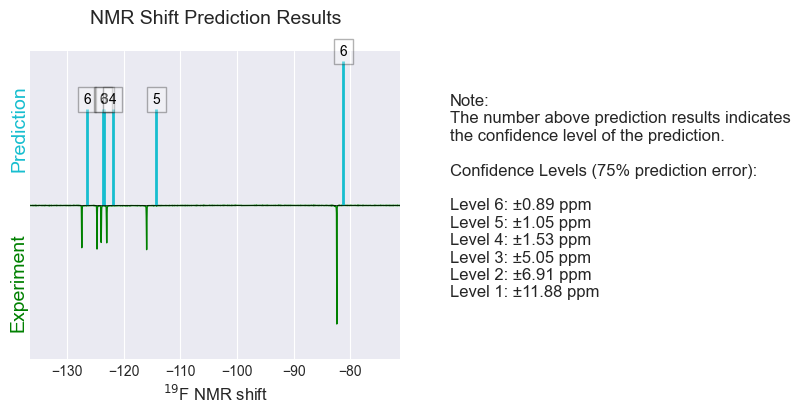

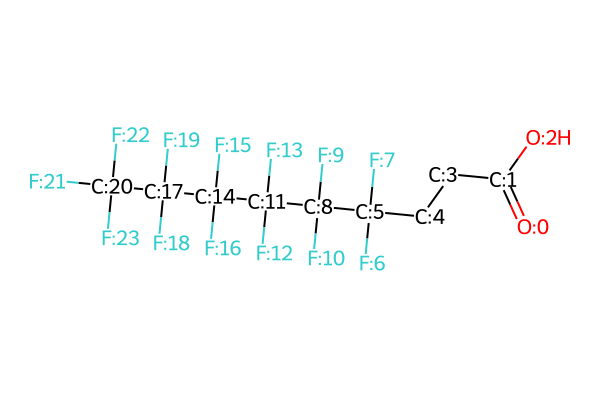

Peak at -64.56804124 with relative height 3.0
Peak at -82.41377632 with relative height 2.4627833460077695
Peak at -115.929465 with relative height 0.9175783351566046
Peak at -122.9666102 with relative height 0.7762376256212435
Peak at -123.938883 with relative height 0.7684859197951208
Peak at -124.6785676 with relative height 0.9050498980576296
Peak at -127.3600931 with relative height 0.8773594129010572


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,8,6,nan,-81.23,nan
1,9,6,nan,-81.23,nan
2,10,6,nan,-81.23,nan
3,11,6,nan,-126.43,nan
4,12,6,nan,-126.43,nan
5,13,6,nan,-123.60,nan
6,14,6,nan,-123.60,nan
7,15,3,nan,-123.39,nan
8,16,3,nan,-123.39,nan
9,17,4,nan,-121.93,nan


In [14]:
# 43: 27854-30-4  C(CC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)C(=O)O
# 136: 21837-98-9  C(=O)(C(OC(F)(F)F)(F)F)[O-].[Na+]
# 2: 422-64-0     C(=O)(C(C(F)(F)F)(F)F)O

# 2,3,3,3-Tetrafluoro-2-(1,1,2,3,3,3-hexafluoro-2-(perfluoropropoxy)propoxy)propanoic acid
# 132: 13252-14-7  C(=O)(C(C(F)(F)F)(OC(C(C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)O

# Potassium perfluorohexanesulfonate
# 66: 3871-99-6   C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F.[K+]
# 63: 2926-30-9    C(F)(F)(F)S(=O)(=O)[O-].[Na+]
# 59: 17372-33-2   C(C(C(F)(F)F)C(F)(F)F)C(=O)O
# 49:359-49-9   C(C(=O)O)(C(F)(F)F)F
# 35: 380-60-9    C(C(=O)O)C(C(F)(F)F)(F)F
file_smiles_dict = {
    "43": "C(CC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)C(=O)O",
    "136": "C(=O)(C(OC(F)(F)F)(F)F)[O-].[Na+]",
    "2": "C(=O)(C(C(F)(F)F)(F)F)O",
    "132": "C(=O)(C(C(F)(F)F)(OC(C(C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)O",
    "66": "C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F.[K+]",
    "63": "C(F)(F)(F)S(=O)(=O)[O-].[Na+]",
    "59": "C(C(C(F)(F)F)C(F)(F)F)C(=O)O",
    "49": "C(C(=O)O)(C(F)(F)F)F",
    "35": "C(C(=O)O)C(C(F)(F)F)(F)F",
}

# Must provide the experimental data file in the 'temp' folder
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["43"], experimental_data_file_name="43.csv"
)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


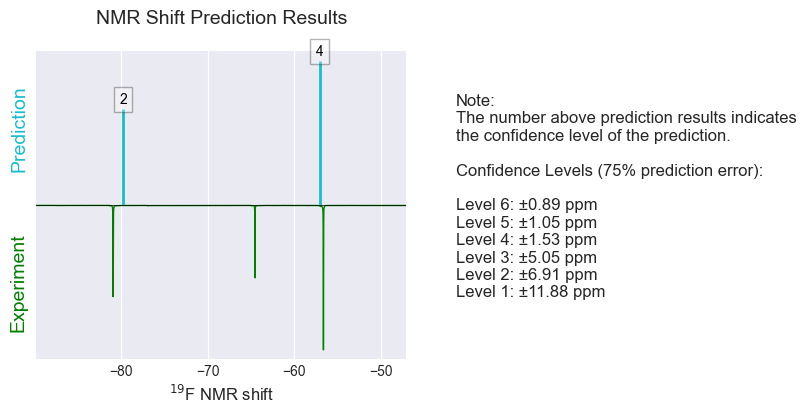

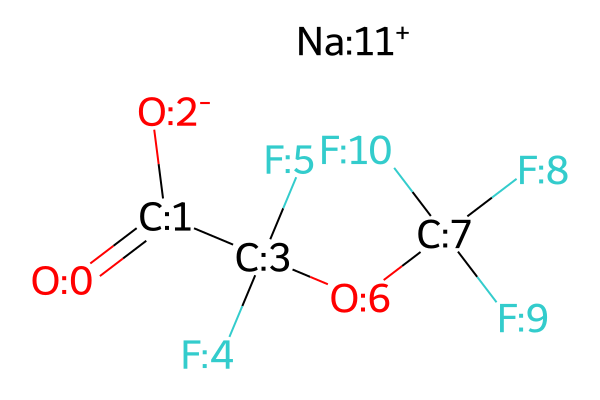

Peak at -56.63029288989877 with relative height 3.0
Peak at -64.53423481271315 with relative height 1.5041078981721578
Peak at -80.8884304696023 with relative height 1.891630431856488
Peak at -80.90195303918796 with relative height 1.8878395133532473


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,5,4,nan,-57.08,nan
1,6,4,nan,-57.08,nan
2,7,4,nan,-57.08,nan
3,8,2,nan,-79.76,nan
4,9,2,nan,-79.76,nan


In [15]:
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["136"], experimental_data_file_name="136.csv"
)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


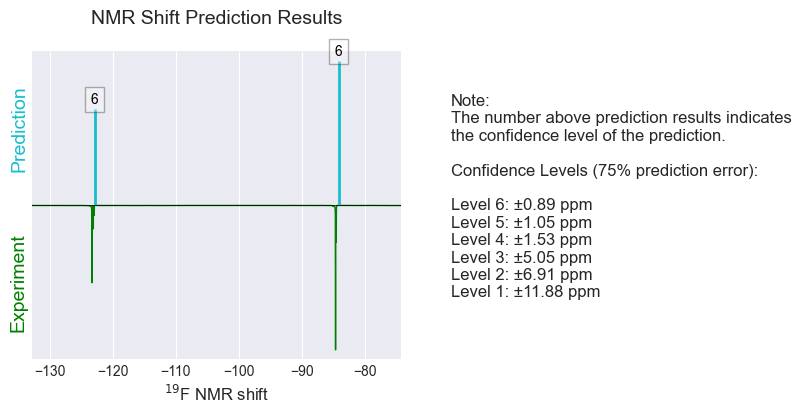

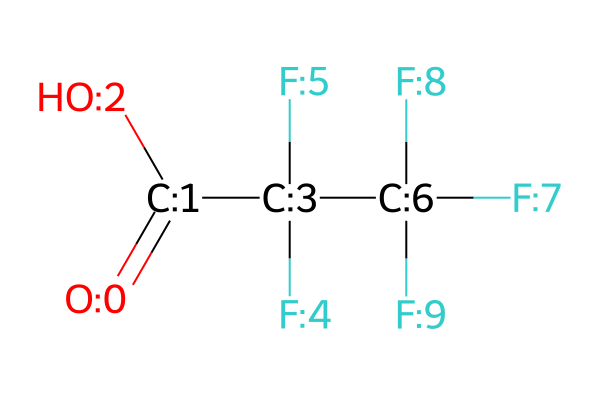

Peak at -64.33815755372117 with relative height 1.580206854163687
Peak at -84.50707009072315 with relative height 0.7625521084300775
Peak at -84.5868532512785 with relative height 0.4096051199644283
Peak at -84.6260687030769 with relative height 3.0
Peak at -122.97337153407264 with relative height 0.2065471603925638
Peak at -123.12211979951482 with relative height 0.4855322055895485
Peak at -123.34794671159524 with relative height 1.6052099402189604


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,4,6,nan,-84.15,nan
1,5,6,nan,-84.15,nan
2,6,6,nan,-84.15,nan
3,7,6,nan,-122.94,nan
4,8,6,nan,-122.94,nan


In [16]:
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["2"], experimental_data_file_name="2.csv"
)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


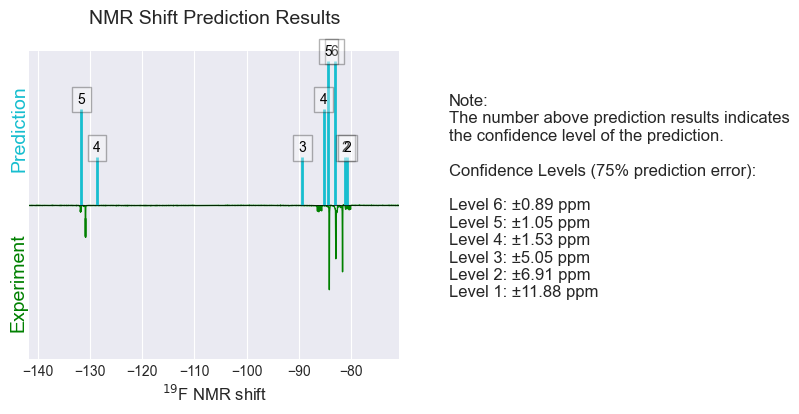

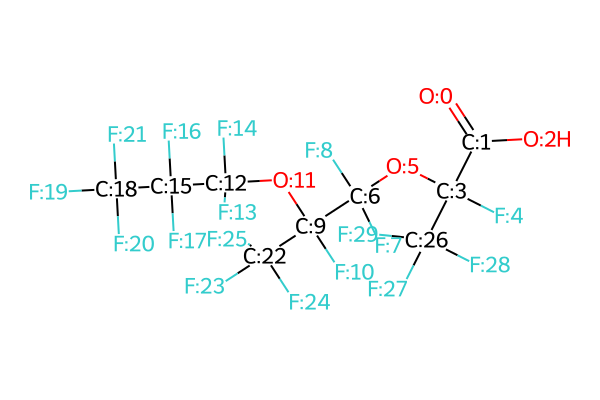

Peak at -64.58021155 with relative height 3.0
Peak at -81.55374089 with relative height 1.3777354947907017
Peak at -82.84514629 with relative height 1.1067804603803248
Peak at -84.07029109 with relative height 1.7400660450280934
Peak at -84.09463172 with relative height 1.7497761158840142
Peak at -85.57129632 with relative height 0.11159930350309659
Peak at -85.83363417 with relative height 0.10321084159636634
Peak at -86.11355136 with relative height 0.13049824992044343
Peak at -86.37318469 with relative height 0.11860431568790328
Peak at -130.9084154 with relative height 0.6628007689140974
Peak at -130.9408695 with relative height 0.6455569114870328
Peak at -131.8036095 with relative height 0.12809172282833908
Peak at -131.8982675 with relative height 0.13240224090355515
Peak at -146.5634942 with relative height 0.10506255608203513


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,4,5,nan,-84.30,nan
1,5,5,nan,-84.30,nan
2,6,5,nan,-84.30,nan
3,11,3,nan,nan,nan
4,12,3,nan,nan,nan
5,13,3,nan,-89.30,nan
6,18,6,nan,-83.10,nan
7,19,6,nan,-83.10,nan
8,20,6,nan,-83.10,nan
9,21,5,nan,-131.70,nan


In [17]:
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["132"], experimental_data_file_name="132.csv"
)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


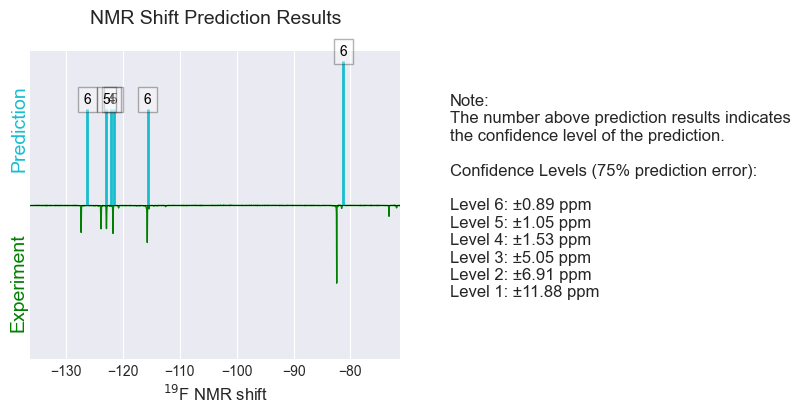

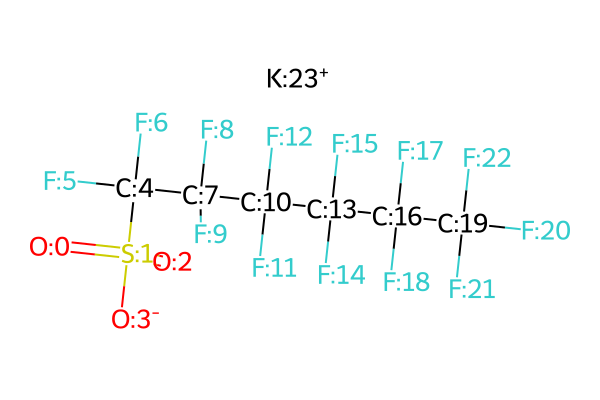

Peak at -64.55316641 with relative height 3.0
Peak at -73.21437223 with relative height 0.22450263495065903
Peak at -82.41242406 with relative height 1.6136601856025696
Peak at -115.7306833 with relative height 0.7692090790459813
Peak at -121.7563403 with relative height 0.5801923298218286
Peak at -122.9098155 with relative height 0.4800566107721073
Peak at -123.8577476 with relative height 0.4850746988892233
Peak at -127.3573886 with relative height 0.5598862792398295


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,4,6,nan,-115.69,nan
1,5,6,nan,-115.69,nan
2,10,5,nan,-121.67,nan
3,11,5,nan,-121.67,nan
4,12,4,nan,-122.03,nan
5,13,4,nan,-122.03,nan
6,16,6,nan,-81.23,nan
7,17,6,nan,-81.23,nan
8,18,6,nan,-81.23,nan
9,19,6,nan,-126.29,nan


In [18]:
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["66"], experimental_data_file_name="66.csv"
)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


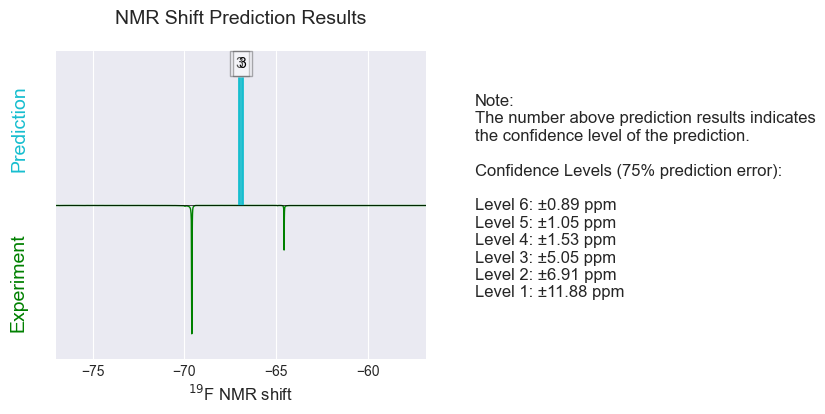

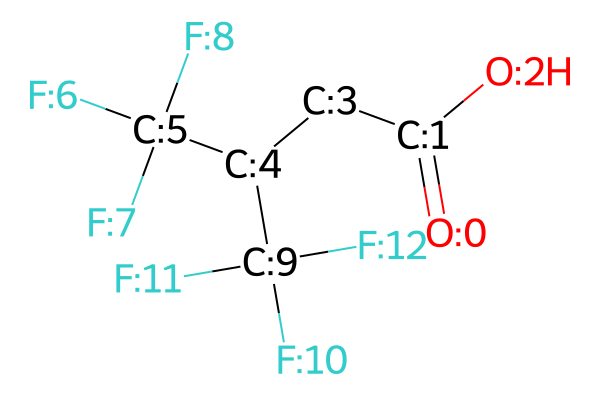

Peak at -64.56939349 with relative height 0.3471841297260577
Peak at -69.60114164 with relative height 1.0


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,3,3,nan,nan,nan
1,4,3,nan,nan,nan
2,5,3,nan,nan,nan
3,7,3,nan,-67.02,nan
4,8,3,nan,-66.86,nan
5,9,3,nan,nan,nan


In [19]:
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["59"], experimental_data_file_name="59.csv"
)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


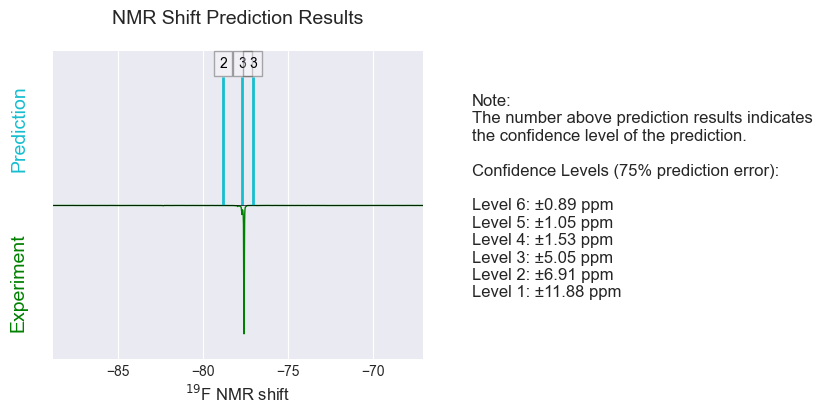

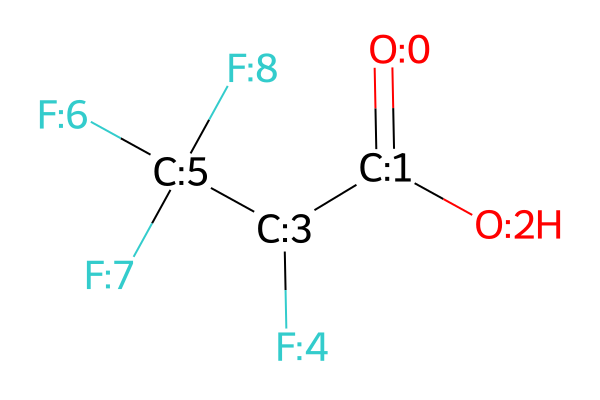

Peak at -64.57345026 with relative height 0.6753289745543387
Peak at -77.59433252 with relative height 1.0


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,5,3,nan,nan,nan
1,6,3,nan,-77.70,nan
2,7,3,nan,-77.07,nan
3,8,2,nan,-78.83,nan


In [20]:
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["49"], experimental_data_file_name="49.csv"
)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


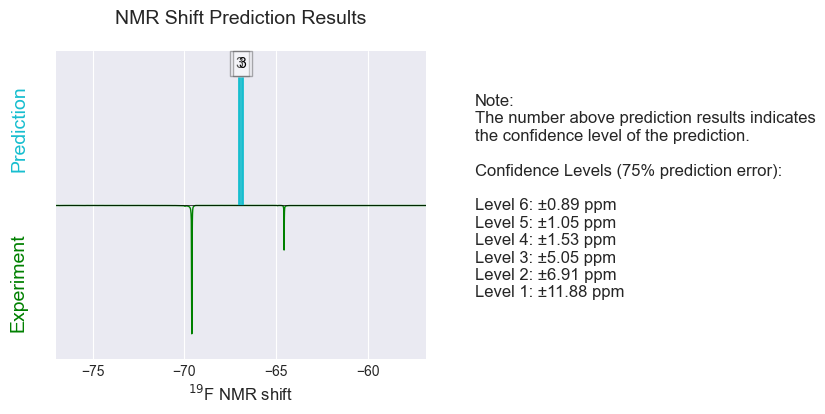

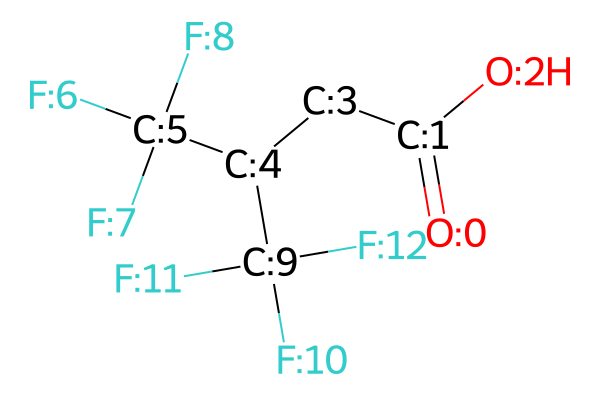

Peak at -64.56939349 with relative height 0.3471841297260577
Peak at -69.60114164 with relative height 1.0


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,3,3,nan,nan,nan
1,4,3,nan,nan,nan
2,5,3,nan,nan,nan
3,7,3,nan,-67.02,nan
4,8,3,nan,-66.86,nan
5,9,3,nan,nan,nan


In [21]:
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["59"], experimental_data_file_name="59.csv"
)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_11691/3878139313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = results["fluorinated_compounds"][0]


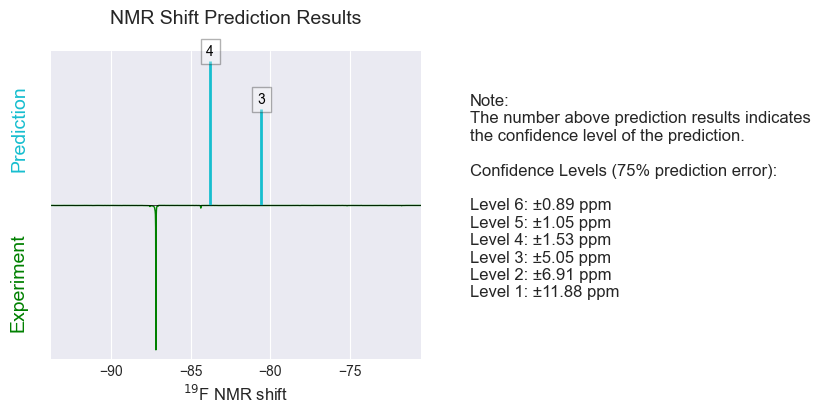

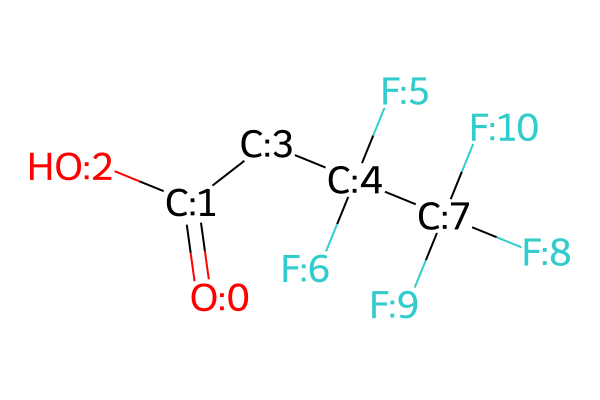

Peak at -64.57885929 with relative height 0.942971503003228
Peak at -87.17507307 with relative height 3.0
Peak at -117.4926741 with relative height 0.5730070205122879
Peak at -117.5251282 with relative height 1.1158076471401972
Peak at -117.5562302 with relative height 0.6162414152686752


,Atom Index,Confidence Level,Report Values,Prediction Results,Prediction Error
0,6,4,nan,-83.77,nan
1,7,4,nan,-83.77,nan
2,8,4,nan,-83.77,nan
3,9,3,nan,-80.55,nan
4,10,3,nan,-80.55,nan


In [22]:
compare_prediction_w_experimental_data(
    smiles=file_smiles_dict["35"], experimental_data_file_name="35.csv"
)